Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [2]:
data = pd.read_csv('data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [3]:
from sklearn.linear_model import LinearRegression

X = data.drop(['target'], axis=1)
Y = data['target']

model=LinearRegression()
model.fit(X, Y)

print(", ".join([str(round(i, 3)) for i in model.coef_.tolist() + [model.intercept_]]))

1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 4.373


Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [4]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - Y).values

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [5]:
### Возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [6]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

### Эта логика поможем Вам при реализации класса!

In [7]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии
    """

    def __init__(
        self,
        samples: pd.DataFrame,
        targets: pd.DataFrame,
        learning_rate: float = 1e-3,
        threshold=1e-6,
        copy: bool = True,
    ):
        """
        :param samples: матрица объектов
        :param targets: вектор (матрица с 1 столбцом) ответов
        :param learning_rate: параметр learning_rate для корректировки нормы градиента
        :param threshold: величина, меньше которой изменение в loss-функции означает
        :param copy: копировать сэмплы или делать изменения in-place (см. add_constant_feature)
        """
        self.iteration_loss_dict = {}
        self.samples = samples.copy().values if copy else samples.values
        self.targets = targets.values
        self.learning_rate = learning_rate
        self.threshold = threshold

    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        """
        self.samples = np.c_[self.samples, np.ones(self.samples.shape[0])]

    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки

        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        scalar_value = np.dot(self.samples, self.beta)
        scalar_value = scalar_value - self.targets
        scalar_value = scalar_value**2

        return np.mean(scalar_value)

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента

        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        gradient = []

        for j in range(self.samples.shape[1]):
            d_ij = self.samples[:, j]
         
            gradient.append(2 * np.mean((np.dot(self.samples, self.beta) - self.targets) * d_ij))

        return np.array(gradient)

    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        self.beta = self.beta - (self.learning_rate * self.calculate_gradient())

    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        """
        self.beta = np.zeros(self.samples.shape[1])

        iteration_number = 0
        self.iteration()
        self.iteration_loss_dict[iteration_number] = self.calculate_mse_loss()

        while True:
            iteration_number += 1
            self.iteration()
            self.iteration_loss_dict[iteration_number] = self.calculate_mse_loss()

            if (
                abs(
                    self.iteration_loss_dict[iteration_number]
                    - self.iteration_loss_dict[iteration_number - 1]
                )
                <= self.threshold
            ):
                break

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [8]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [9]:
print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

[0.88463252 1.90068535 2.87930626 3.87593146 4.89600908 5.89186066
 6.89362691 7.90440284 8.87680822 9.86175597 4.94886926]


Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [ ]:
GD = GradientDescentMse(samples=X, targets=Y, learning_rate=1)
GD.add_constant_feature()
GD.learn()

C:\Users\Kirill\anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Kirill\AppData\Local\Temp/ipykernel_3244/764749931.py:83: RuntimeWarning: invalid value encountered in double_scalars
  self.iteration_loss_dict[iteration_number]
C:\Users\Kirill\AppData\Local\Temp/ipykernel_3244/764749931.py:41: RuntimeWarning: overflow encountered in square
  scalar_value = scalar_value**2
C:\Users\Kirill\AppData\Local\Temp/ipykernel_3244/764749931.py:64: RuntimeWarning: invalid value encountered in subtract
  self.beta = self.beta - (self.learning_rate * self.calculate_gradient())


В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


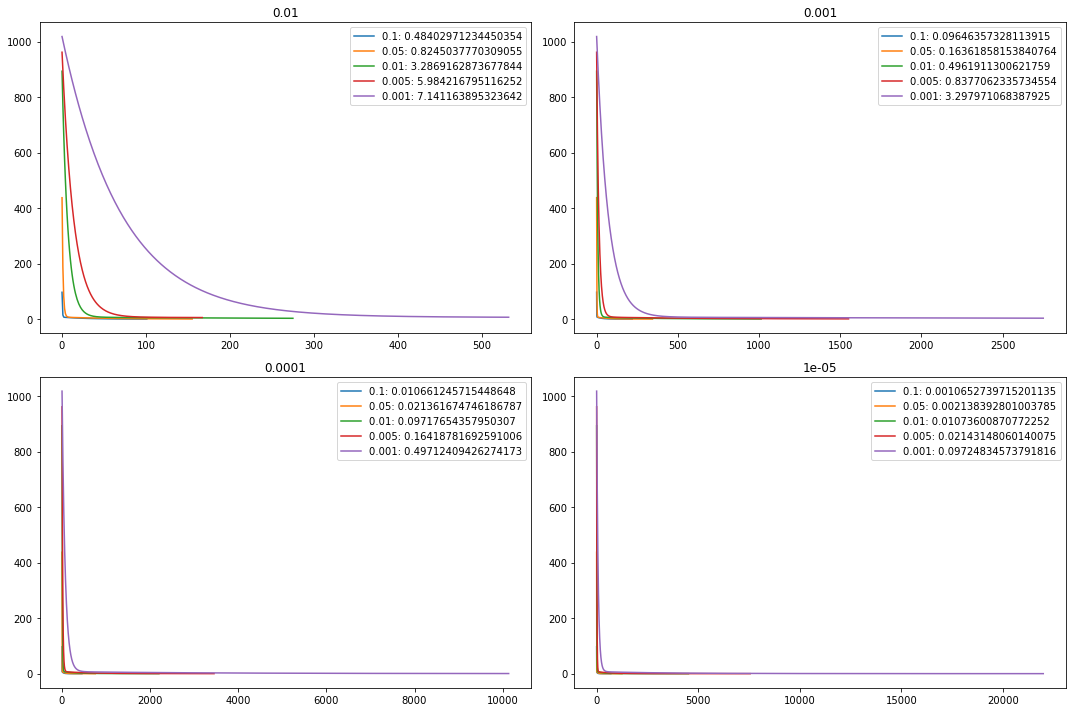

In [21]:
### Нарисуем несколько графиков сразу!

fig = plt.figure()

fig.set_size_inches(15, 10)

thresholds = [1e-2, 1e-3, 1e-4, 1e-5]
learning_rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

index = 1

for t in thresholds:
    ### Создадим первый график на нашем полотне
    ax1 = fig.add_subplot(2, 2, index)
    
    index += 1
    
    legend = []
    
    for r in learning_rates:
        GD = GradientDescentMse(samples=X, targets=Y, threshold=t, learning_rate=r)
        GD.add_constant_feature()
        GD.learn()

        x = [k for k, v in GD.iteration_loss_dict.items()]
        y = [v for k, v in GD.iteration_loss_dict.items()]

        plt.plot(x, y) 
        
        legend.append(f'{r}: {GD.calculate_mse_loss()}')
        
    plt.title(t)    
    plt.legend(legend)
    
    
### Сделаем поприличнее расстояние между графиками
fig.tight_layout()

### Установим у графиков названия разные
plt.show()